# QuTiP example: Landau-Zener transitions

J.R. Johansson and P.D. Nation

For more information about QuTiP see [http://qutip.org](http://qutip.org)

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
from qutip import *

In [5]:
import time

In [6]:
def hamiltonian_t(t, args):
    """ evaluate the hamiltonian at time t. """
    H0 = args[0]
    H1 = args[1]

    return H0 + t * H1

In [7]:
def qubit_integrate(delta, eps0, A, gamma1, gamma2, psi0, tlist):

    # Hamiltonian
    sx = sigmax()
    sz = sigmaz()
    sm = destroy(2)

    H0 = - delta/2.0 * sx - eps0/2.0 * sz
    H1 = - A/2.0 * sz        

    # collapse operators
    c_op_list = []

    n_th = 0.0 # zero temperature

    # relaxation
    rate = gamma1 * (1 + n_th)
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * sm)

    # excitation
    rate = gamma1 * n_th
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * sm.dag())

    # dephasing 
    rate = gamma2
    if rate > 0.0:
        c_op_list.append(sqrt(rate) * sz)

    # evolve and calculate expectation values

    # method 1: function callback which returns the time-depdent qobj
    #H_args = (H0, H1)
    #output = mesolve(hamiltonian_t, psi0, tlist, c_op_list, [sm.dag() * sm], H_args)  

    # method 2: a function callback that returns the coefficient for a qobj
    #H = [H0, [H1, lambda x,y: x]]
    #output = mesolve(H, psi0, tlist, c_op_list, [sm.dag() * sm], {})  

    # method 3: a string that defines the coefficient. The solver generates
    # and compiles C code using cython. This method is usually the fastest
    # for large systems or long time evolutions, but there is fixed-time
    # overhead that makes it inefficient for small and short-time evolutions.
    H = [H0, [H1, 't']]
    output = mesolve(H, psi0, tlist, c_op_list, [sm.dag() * sm], {})  

    return output.expect[0]

In [8]:
#
# set up the calculation
#
delta = 0.5 * 2 * np.pi   # qubit sigma_x coefficient
eps0  = 0.0 * 2 * np.pi   # qubit sigma_z coefficient
A     = 2.0 * 2 * np.pi   # sweep rate
gamma1 = 0.0           # relaxation rate
gamma2 = 0.0           # dephasing  rate
psi0 = basis(2,0)      # initial state

tlist = np.linspace(-20.0, 20.0, 5000)

In [9]:
start_time = time.time()
p_ex = qubit_integrate(delta, eps0, A, gamma1, gamma2, psi0, tlist)
print('time elapsed = ' + str(time.time() - start_time))

time elapsed = 11.346536874771118


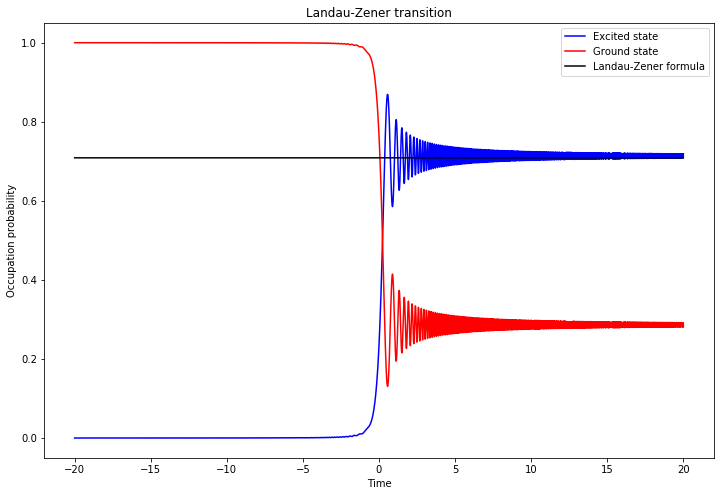

In [10]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(tlist, np.real(p_ex), 'b', tlist, np.real(1-p_ex), 'r')
ax.plot(tlist, 1 - np.exp(-np.pi * delta **2 / (2 * A)) * np.ones(shape(tlist)), 'k')
ax.set_xlabel('Time')
ax.set_ylabel('Occupation probability')
ax.set_title('Landau-Zener transition')
ax.legend(("Excited state", "Ground state", "Landau-Zener formula"), loc=0);

## Steady state of strongly driven two-level system (repeated LZ transitions)

In [11]:
def qubit_integrate(delta, eps0, A, omega, gamma1, gamma2, psi0, tlist, option):

    # Hamiltonian
    sx = sigmax()
    sz = sigmaz()
    sm = destroy(2)

    H0 = - delta/2.0 * sx - eps0/2.0 * sz
    H1 = - A/2.0 * sz
        
    H = [H0, [H1, 'cos(w*t)']]
    H_args = {'w' : omega}
    # collapse operators
    c_op_list = []

    n_th = 0.0 # zero temperature

    # relaxation
    rate = gamma1 * (1 + n_th)
    if rate > 0.0:
        c_op_list.append(np.sqrt(rate) * sm)

    # excitation
    rate = gamma1 * n_th
    if rate > 0.0:
        c_op_list.append(np.sqrt(rate) * sm.dag())

    # dephasing 
    rate = gamma2
    if rate > 0.0:
        c_op_list.append(np.sqrt(rate) * sz)

    if option == "dynamics":
        # evolve and calculate expectation values
        output = mesolve(H, psi0, tlist, c_op_list, [sm.dag() * sm], H_args)  

        return output.expect[0]

    else: # option = steadystate

        # find the propagator for one driving period
        T = 2*np.pi / omega
        U = propagator(H, T, c_op_list, H_args, options=Odeoptions(nsteps=5000))

        # find the steady state of successive application of the propagator
        rho_ss = propagator_steadystate(U)

        return np.real(expect(sm.dag() * sm, rho_ss))

In [12]:
#
# set up the calculation: a strongly driven two-level system
# (repeated LZ transitions)
#
delta = 0.05 * 2 * np.pi  # qubit sigma_x coefficient
eps0  = 0.0  * 2 * np.pi  # qubit sigma_z coefficient
A     = 2.0  * 2 * np.pi  # sweep rate
gamma1 = 0.0001        # relaxation rate
gamma2 = 0.005         # dephasing  rate
psi0   = basis(2,0)    # initial state
omega  = 0.05 * 2 * np.pi # driving frequency
T      = (2*np.pi)/omega  # driving period

tlist = np.linspace(0.0, 3 * T, 1500)

### Steady state and dynamics for a fixed driving amplitude

In [13]:
start_time = time.time()
p_ex = qubit_integrate(delta, eps0, A, omega, gamma1, gamma2, psi0, tlist, "dynamics")
print('dynamics: time elapsed = ' + str(time.time() - start_time))

dynamics: time elapsed = 4.77644419670105


In [14]:
start_time = time.time()
p_ex_ss = qubit_integrate(delta, eps0, A, omega, gamma1, gamma2, psi0, tlist, "steadystate")
print('steady state: time elapsed = ' + str(time.time() - start_time))

steady state: time elapsed = 24.038254261016846


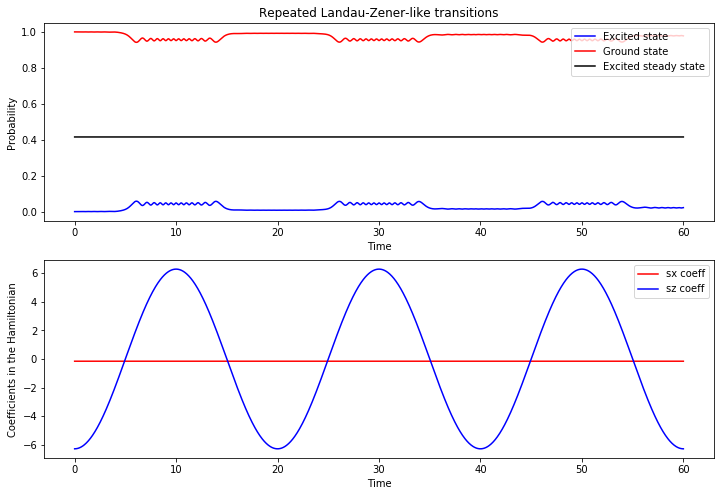

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(tlist, np.real(p_ex), 'b', tlist, np.real(1-p_ex), 'r', 
         tlist, np.ones(np.shape(tlist)) * p_ex_ss, 'k')
ax1.set_xlabel('Time')
ax1.set_ylabel('Probability')
ax1.set_title('Repeated Landau-Zener-like transitions')
ax1.legend(("Excited state", "Ground state", "Excited steady state"), loc=0)

ax2.plot(tlist, -delta/2.0 * np.ones(np.shape(tlist)), 'r')
ax2.plot(tlist, -(eps0/2.0 + A/2.0 * np.cos(omega * tlist)), 'b')
ax2.legend(("sx coeff", "sz coeff"))
ax2.set_xlabel('Time')
ax2.set_ylabel('Coefficients in the Hamiltonian');

### Steady state as a function of driving amplitude

In [ ]:
start_time = time.time()

A_vec = 2 * np.pi * np.linspace(0.0, 5.0, 100)

p_ex_ss_vec = np.zeros(len(A_vec))
idx = 0
start_time = time.time()
for A in A_vec:
    
    p_ex_ss_vec[idx] = qubit_integrate(delta, eps0, A, omega, gamma1, gamma2, psi0, tlist, "steadystate")
    idx += 1

print('time elapsed = ' + str(time.time() - start_time))

In [ ]:
fig, ax = plt.subplots()

ax.plot(A_vec/(2*np.pi), p_ex_ss_vec, 'b.-')
ax.set_title("Steady state of repeated LZ transitions")
ax.set_xlabel("driving amplitude")
ax.set_ylabel("Occupation probability");

## Steadystate of a strongly driven two-level system as a function of driving amplitude and qubit bias

Find the steady state of a strongly driven qubit as a function of driving amplitude and qubit bias. 

Note: This calculation can takes a long time.

In [ ]:
def hamiltonian_t(t, args):
    #
    # evaluate the hamiltonian at time t. 
    #
    H0 = args[0]
    H1 = args[1]
    w  = args[2]

    return H0 + H1 * np.sin(w * t)

In [ ]:
def sd_qubit_integrate(delta, eps0_vec, A_vec, w, gamma1, gamma2):

    # Hamiltonian
    sx = sigmax()
    sz = sigmaz()
    sm = destroy(2)

    # collapse operators
    c_op_list = []

    n_th = 0.0 # zero temperature

    # relaxation
    rate = gamma1 * (1 + n_th)
    if rate > 0.0:
        c_op_list.append(np.sqrt(rate) * sm)

    # excitation
    rate = gamma1 * n_th
    if rate > 0.0:
        c_op_list.append(np.sqrt(rate) * sm.dag())

    # dephasing 
    rate = gamma2
    if rate > 0.0:
        c_op_list.append(np.sqrt(rate) * sz)


    N = len(A_vec)
    M = len(eps0_vec)
    p_ex = np.zeros([N, M]) #, dtype=complex)

    T = 2 * np.pi / w

    sn = sm.dag() * sm

    # sweep over the driving amplitude and bias point, find the steady state 
    # for each point and store in a matrix
    for n in range(0, N):
        for m in range(0, M):

            H0 = - delta/2.0 * sx - eps0_vec[m]/2.0 * sz
            H1 = - A_vec[n] * sx
            
            H = [H0, [H1, 'sin(w * t)']]
            
            H_args = {'w': omega}
            
            # find the propagator for one period of the time-dependent
            # hamiltonian
            U = propagator(H, T, c_op_list, H_args)

            # find the steady state of the driven system 
            rho_ss = propagator_steadystate(U)
        
            p_ex[n, m] = np.real(expect(sn, rho_ss))

    return p_ex

In [ ]:
#
# set up the parameters
#
delta = 0.2  * 2 * np.pi   # qubit sigma_x coefficient
w     = 1.0  * 2 * np.pi   # qubit sigma_z coefficient

A_vec    = np.linspace(0.0, 4.0, 100) * 2 * np.pi  # driving amplitude
eps0_vec = np.linspace(0.0, 4.0, 100) * 2 * np.pi  # qubit sigma-z bias point

gamma1 = 0.05          # relaxation rate
gamma2 = 0.0           # dephasing  rate

In [ ]:
start_time = time.time()
p_ex = sd_qubit_integrate(delta, eps0_vec, A_vec, w, gamma1, gamma2)
print('time elapsed = ' + str(time.time() - start_time))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
p = ax.pcolor(A_vec, eps0_vec, np.real(p_ex), edgecolors='none')
p.set_cmap('RdYlBu_r')
ax.set_ylabel(r'$A/\omega$', fontsize=20)
ax.set_xlabel(r'$\epsilon_0/\omega$', fontsize=20)
ax.axis('tight')
ax.set_title('Excitation probabilty of qubit, in steady state', fontsize=16);

## Versions

In [ ]:
from qutip.ipynbtools import version_table

version_table()